# Ideal Diode Example

## Introduction
This is meant to be a (relatively) self-contained example of using `bayesim` to perform a fit - in this case, fitting solar cell outputs to a simple diode model. In this case, we use the same model function to generate our "observed" data as the one we use to fit; this allows us to confirm that `bayesim` can retrieve the same input parameters and get the right answer under a very controlled setting.

The overall procedure is:
1. Define parameters to be fit (starting on a 20 x 20 grid) and initialize a uniform prior probability distribution
2. Generate the "observed" data and import it (there will be 59 different observation conditions)
3. Generate the modeled data to compare to observations - this will be done at every set of experimental conditions that were observed and at every point in the space defined by the fitting parameters (20 x 20 x 59 model computations)
4. Use Bayesian inference to compute the posterior probability distribution over the fitting parameters.
5. Choose a region of the fitting parameter space exceeding some threshold probability density and resample this region more densely (subdivide each grid box), discarding points outside the region.
6. Compute the new modeled data over this new fitting parameter space.
7. Repeat steps 4-6 until desired fit precision is reached.

## How to use this notebook
In many of the code cells, I've included commented-out lines representing alternative options to try. I suggest you step through the whole notebook once (evaluate each cell using <kbd>Shift</kbd>+<kbd>Enter</kbd>) without changing these to understand what's going on, then go back to the beginning and start tweaking them to see how the different options impact the progress and results of the fitting process.

## The ideal diode model

The simplest way to model a solar cell (current density $J$ as a function of voltage $V$ and temperature $T$) is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
# import some code that we'll need
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. List the parameters
First, we list our fitting parameters, specifying their names, ranges of values, spacing, lengths, and units.

In [19]:
pl = byp.Param_list()
pl.add_fit_param(name='Bp', display_name="B'", val_range=[10,1000], spacing='log', length=20, units='arb.')
pl.add_fit_param(name='n', val_range=[1,2], length=20, min_width=0.01) # units default to "unitless"

# --------- alternative options --------
# try different val_range or length or play with min_width to see what it does with subdivisions later

We can inspect the `Param_list` object and see what kind of information is inside...

In [20]:
print(pl)

{
    "ec_x_name": null,
    "ecs": [],
    "fit_params": [
        {
            "spacing": "log",
            "length": 20,
            "name": "Bp",
            "units": "arb.",
            "tolerance": 1.0023052380778996,
            "display_name": "B'",
            "val_range": "[10, 1000]",
            "edges": "[  10.      12.589   15.849   19.953   25.119   31.623   39.811   50.1...",
            "vals": "[ 11.22   14.125  17.783  22.387  28.184  35.481  44.67   56.23   70.7...",
            "min_width": 1.023292992280754
        },
        {
            "spacing": "linear",
            "length": 20,
            "name": "n",
            "units": "unitless",
            "tolerance": 0.001,
            "display_name": "n",
            "val_range": "[1, 2]",
            "edges": "[1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6...",
            "vals": "[1.025, 1.075, 1.125, 1.175, 1.225, 1.275, 1.325, 1.375, 1.425, 1.475,...",
            "min_width": 0.01,

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the experimental conditions (EC's for short) and output variable. We won't be varying light intensity here, so we only need voltage and temperature. We also set voltage as the parameter to be plotted on the x-axis when visualizing data.

In [21]:
pl.add_ec(name='V', units='V', is_x=True) # this will be on the x-axis when we plot data
pl.add_ec(name='T', units='K', tolerance=0.1) # tolerance is how precisely we care about knowing this variable's value
pl.add_output(name='J', units='A/cm^2')

In [5]:
print(pl)

{
    "ec_x_name": "V",
    "ecs": [
        {
            "name": "V",
            "units": "V",
            "tolerance": 1e-06,
            "display_name": "V",
            "param_type": "input",
            "tol_digits": 6
        },
        {
            "name": "T",
            "units": "K",
            "tol_digits": 1,
            "tolerance": 0.1,
            "display_name": "T",
            "param_type": "input"
        }
    ],
    "fit_params": [
        {
            "spacing": "log",
            "length": 20,
            "name": "Bp",
            "units": "arb.",
            "tolerance": 1.0023052380778996,
            "display_name": "Bp",
            "val_range": "[10, 1000]",
            "edges": "[  10.      12.589   15.849   19.953   25.119   31.623   39.811   50.1...",
            "vals": "[ 11.22   14.125  17.783  22.387  28.184  35.481  44.67   56.23   70.7...",
            "min_width": 1.023292992280754
        },
        {
            "spacing": "linear",
        

## Initialize the model
Now we're ready to initialize our bayesim Model object.

In [22]:
m = bym.Model(params=pl)

By default, a uniform probability distribution is created...

In [5]:
m.probs.points.head(10) # head(10) just shows the first ten lines in the DataFrame

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob
0,11.22,10.0,12.589,1.025,1.00,1.05,0.0025
1,11.22,10.0,12.589,1.075,1.05,1.10,0.0025
2,11.22,10.0,12.589,1.125,1.10,1.15,0.0025
3,11.22,10.0,12.589,1.175,1.15,1.20,0.0025
4,11.22,10.0,12.589,1.225,1.20,1.25,0.0025
5,11.22,10.0,12.589,1.275,1.25,1.30,0.0025
6,11.22,10.0,12.589,1.325,1.30,1.35,0.0025
7,11.22,10.0,12.589,1.375,1.35,1.40,0.0025
8,11.22,10.0,12.589,1.425,1.40,1.45,0.0025
9,11.22,10.0,12.589,1.475,1.45,1.50,0.0025


Those `min` and `max` values are describing the edges of the grid boxes, and the parameter values are the centers.

## 2. Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters.

Here we generate and save the synthetic data as well as plot it.

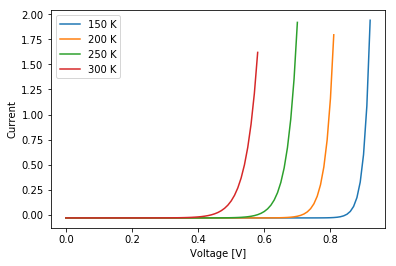

In [10]:
# implement the diode model in a function we can call
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

# define the vectors of experimental conditions
V = np.arange(0,1.0,0.01)
T = [float(t) for t in np.arange(150,301,50)]

# set the "true" values for the parameters
params = {'n':1.36,'Bp':258}

# generate the "observations"
data = []
for t in T:
    J0 = compute_ID({'V':V[0],'T':t},params)
    for v in V:
        J = compute_ID({'V':v,'T':t},params)
        if abs(J)>0.1:
            err = 0.05*abs(J)
        else:
            err = 0.005
        # check for "compliance"
        if not J > 2.0:
            data.append([v,t,J,err])

# save them to HDF5
data = pd.DataFrame.from_records(data=data,columns=['V','T','J','uncertainty'])
dd.io.save('obs_data.h5',data)

# these next few lines are for generating the plot
leg = []
for i in range(len(T)):
    curve = data[data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append('%d K'%curve['T'].iloc[0])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

Let's see how many data points we generated.

In [9]:
len(data)

305

Now that we've generated our "observations," we can attach them to `bayesim`. There are some options when we attach the observations, notably `keep_all` and `max_ec_x_step`. If `keep_all` is set to False, `attach_observations` will only import data points that differ from each other by more than 1% of the full y-axis range (this 1% threshold can be modified with the `thresh_dif_frac` option) in the output variable (J) along the defined x-axis variable (V). However, `max_ec_x_step` tells it to only skip a maximum of 0.2 V before saving a point even if it differs by $<1$% from the previous one.

This allows us to sample more densely in regions where the output variable is changing rapidly and save simulation load in regions where it changes more slowly.

Finally, we define the experimental uncertainty. We could define custom uncertainty values at each measurement point by including an 'uncertainty' column in the file with the observed data. If you would rather use a fixed value of experimental uncertainty for all measurements, use the `fixed_unc` keyword as we do here.

In [23]:
m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.2, fixed_unc=0.0001)

# ---------- alternative options ------------

# don't discard any data
#m.attach_observations(obs_data_path='obs_data.h5', fixed_unc=0.0001)

# changing max_ec_x_step
#m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.1, fixed_unc=0.0001)

# changing thresh_dif_frac
#m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.1, thresh_dif_frac=0.001, fixed_unc=0.0001)

# using uncertainty values from file rather than fixed value
#m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.2)

How many data points of those 305 from before were kept?

In [11]:
len(m.obs_data)

59

Let's take a look at what the data looks like once we've trimmed and imported it - we'll show both the full current range as well as a zoomed-in one to see the impact of discarding some data points.

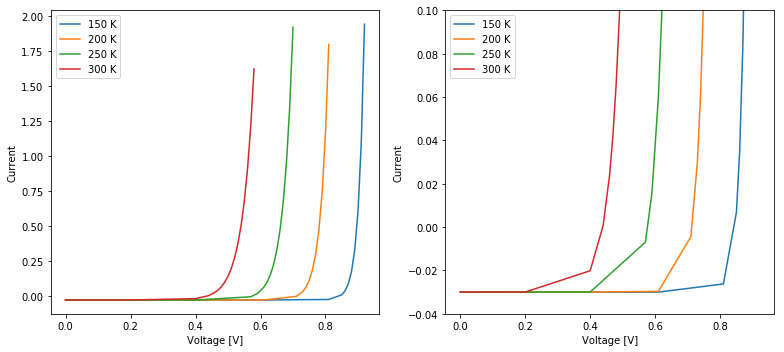

In [12]:
# code for plotting, not critical to understand
fig, ax = plt.subplots(1,2,figsize=(11,5))
leg = []
plt.subplot(1,2,1)
for i in range(len(T)):
    curve = m.obs_data[m.obs_data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append('%d K'%curve['T'].iloc[0])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.subplot(1,2,2)
for i in range(len(T)):
    curve = m.obs_data[m.obs_data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append('%d K'%curve['T'].iloc[0])
plt.ylim([-0.04,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.tight_layout()
plt.show()

## 3. Attach modeled data
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [24]:
m.attach_model(mode='function', model_data_func=compute_ID)

# how to attach from a file instead
#m.attach_model(mode='file',fpath='model_data.h5')

Rounding model data...


When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [14]:
m.model_data.head()

,Bp,J,T,V,n
0,11.22,-0.03,150.0,0.0,1.025
1,11.22,-0.03,200.0,0.0,1.025
2,11.22,-0.03,250.0,0.0,1.025
3,11.22,-0.03,300.0,0.0,1.025
4,11.22,-0.03,150.0,0.2,1.025


We'll also compute the "model uncertainty" - the difference in output variable (at a fixed set of experimental conditions) when one moves around the fitting parameter space. For each point, the likelihood will be calculated with a standard deviation equal to the maximum of the experimental uncertainty and the model uncertainty.

In [25]:
m.calc_model_unc()

In [16]:
m.model_data.sample(5)

,Bp,J,T,V,n,uncertainty
10832,89.130,0.034240,250.0,0.66,1.175,0.011035
1161,11.220,-0.010351,200.0,0.71,1.975,0.002544
16756,281.840,-0.030000,150.0,0.00,1.225,0.000000
5416,28.184,0.157587,200.0,0.79,1.575,0.024284
3708,22.387,0.026293,200.0,0.81,1.125,0.008165


## 4. Drop that Bayes!
We're ready to do our Bayesian inference! The `run` function has many options we can set but can also be called with no arguments to run in the default way. In this case, the default is:

A threshold probability concentration is defined by an amount of probability mass (`th_pm`, defaults to 0.8) and a fraction of the fitting parameter space volume (`th_pv`, defaults to 0.05). `bayesim` chooses observation points randomly (without replacement) for Bayesian updates until at least `th_pm` of the probability resides in at most `th_pv` of the parameter space.

However, depending on the thresholds set, data sampling and other factors, this threshold could potentially take very few observation points to reach, meaning we will inevitably be sampling our experimental conditions unevenly. To address this, a parameter `min_num_pts` is defined (with a default value of 0.7 * the number of observed data points). The procedure just described is repeated until that number of points has been used, and the resulting probability distributions from each cycle are averaged together to produce the final result.

In [26]:
m.run()

# ------- alternative options ------

# different thresholding conditions
#m.run(th_pm=0.9, th_pv=0.02)

# use all the observed data
#m.run(min_num_pts=len(m.obs_data))

Did a total of 38 runs to use a total of 41 observations.


An average of 198 / 400 probability points had larger model uncertainty than experimental uncertainty during this run.


An average of 0.00 / 400 probability points were affected by missing/NaN simulation data.



We can visualize the distribution and add markers for the real values to compare...

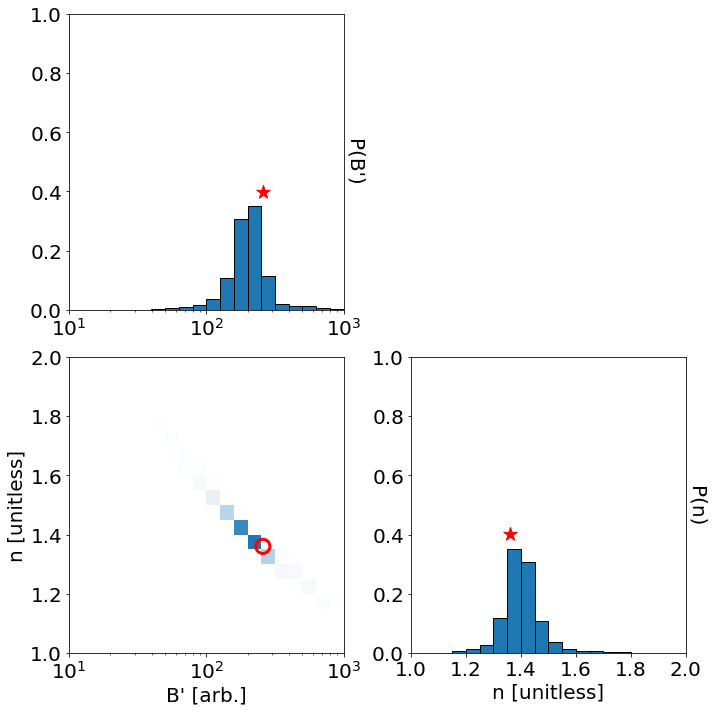

In [28]:
m.visualize_probs(true_vals=params)

We can see that there are multiple points in the parameter space that give similarly good fits to the data - in particular, we see a tradeoff between the $B'$ and $n$ parameters, where we can get a similar fit quality by increasing $B'$ and decreasing $n$. Comfortingly, the locus of high-probability points generally centers about the "true" values.

We can also plot the simulated data corresponding to the most probable points (in this case, three of them) in parameter space and compare to the observed data at the same conditions.

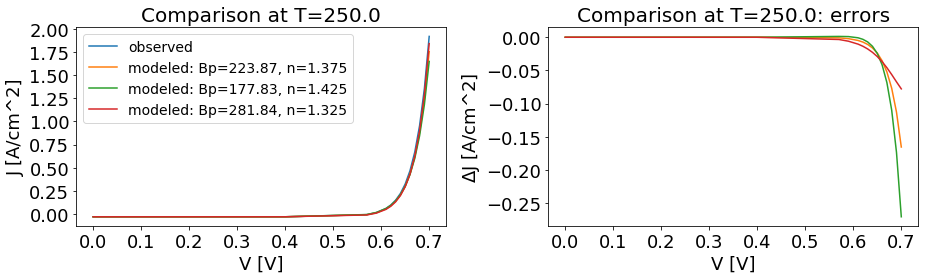

In [30]:
m.comparison_plot(num_param_pts=3)

Not too bad. We can also of course look at the probabilities directly...

In [20]:
m.top_probs(5)

,prob,Bp,Bp_min,Bp_max,n,n_min,n_max
267,0.393837,223.87,199.53,251.19,1.375,1.35,1.40
248,0.269173,177.83,158.49,199.53,1.425,1.40,1.45
286,0.151657,281.84,251.19,316.23,1.325,1.30,1.35
229,0.071432,141.25,125.89,158.49,1.475,1.45,1.50
305,0.022278,354.81,316.23,398.11,1.275,1.25,1.30


## 5. Let's subdivide!
Again we'll use the default options, which will subdivide all grid boxes with probability > 0.001 as well as any immediately adjacent boxes. It will discard any boxes with probability < 0.001. This threshold can be modified with the `threshold_prob` argument.

In [31]:
m.subdivide()

# try a different threshold probability
# m.subdivide(threshold_prob = 0.01)

23 box(es) with probability > 0.001 and 30 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_1.h5.


Let's take a look at the grid.

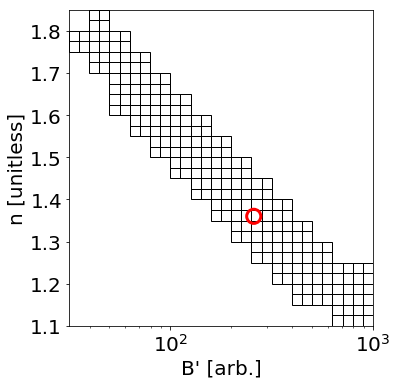

In [33]:
m.visualize_grid(true_vals=params)

## 6. Compute and attach new model data
We've added new model points to the grid so we have to compute the modeled values and attach that data.

In [34]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [35]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [36]:
# calc_model_unc=True runs the model uncertainty calculation without having to make a separate function call
m.attach_model(mode='file', model_data_path='new_sim_data_1.h5', calc_model_unc=True)

Rounding model data...


## 7. Onward!
Let's do it again!

In [39]:
m.run()

Running again at the same subdivision level. Previous results may be overridden...

Did a total of 28 runs to use a total of 41 observations.


An average of 109 / 212 probability points had larger model uncertainty than experimental uncertainty during this run.


An average of 0.00 / 212 probability points were affected by missing/NaN simulation data.



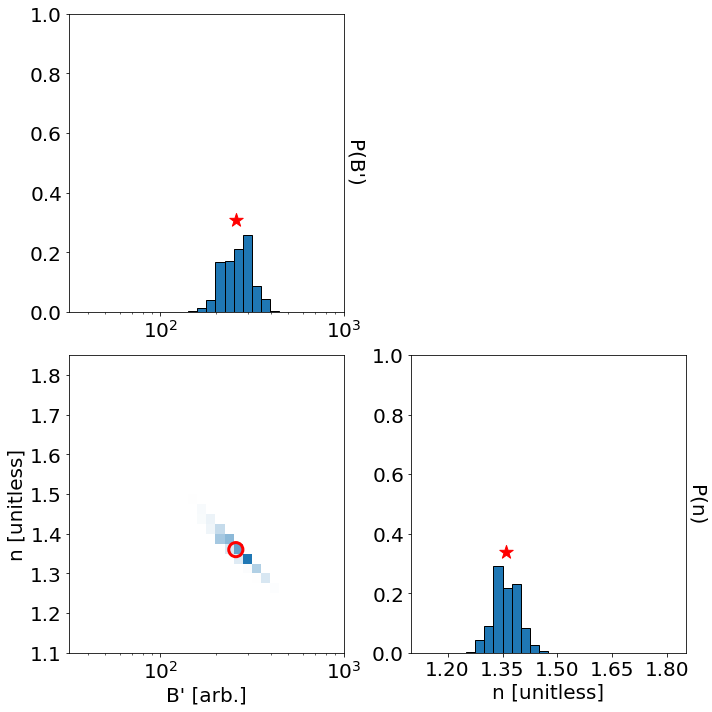

In [40]:
m.visualize_probs(true_vals=params)

Note that the parameter ranges have narrowed slightly...

In [ ]:
m.top_probs(10)

Here's a cool trick with the `comparison_plot` function - we can choose more of the other experimental conditions to plot at!

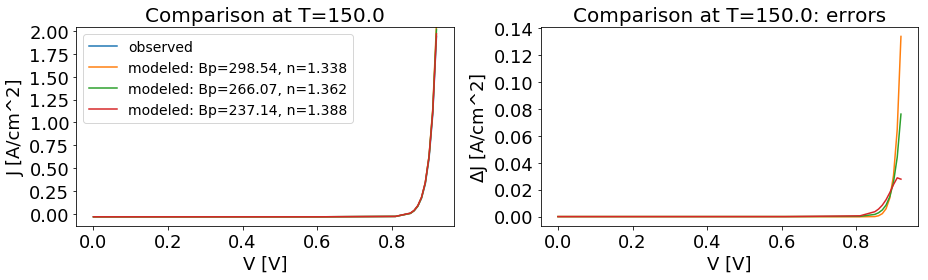

In [41]:
m.comparison_plot(num_param_pts=3)

In [42]:
m.subdivide()

16 box(es) with probability > 0.001 and 23 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_2.h5.


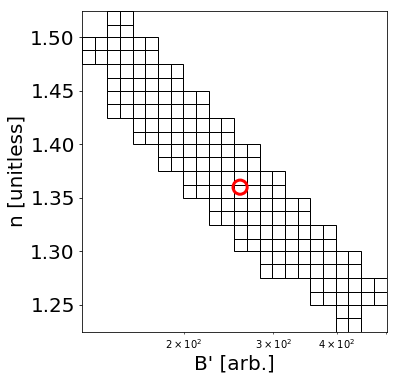

In [43]:
m.visualize_grid(true_vals=params)

In [ ]:
m.probs.points.sample(10)

In [44]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='file', model_data_path='new_sim_data_2.h5', calc_model_unc=True)

Rounding model data...


In [45]:
m.run()

Did a total of 7 runs to use a total of 41 observations.


An average of 4 / 156 probability points had larger model uncertainty than experimental uncertainty during this run.


An average of 0.00 / 156 probability points were affected by missing/NaN simulation data.



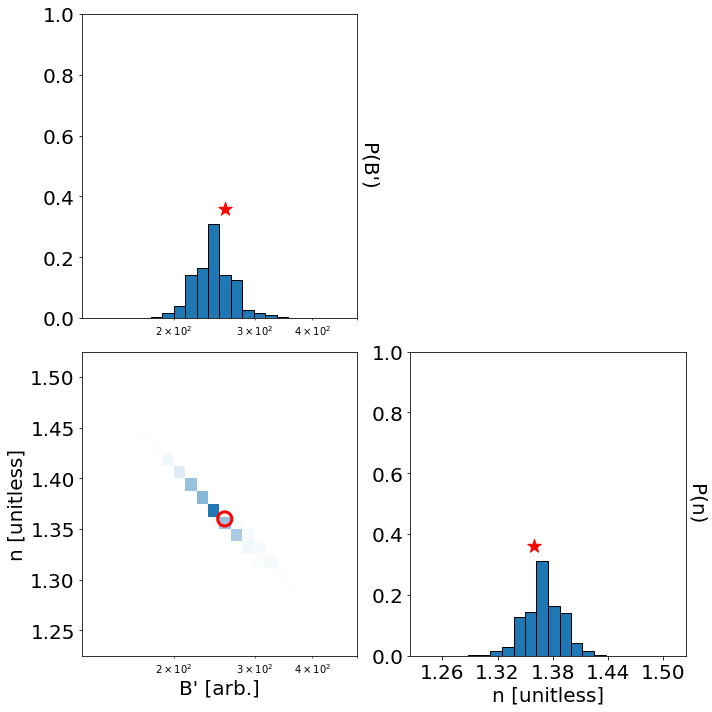

In [46]:
m.visualize_probs(true_vals=params)

In [ ]:
m.top_probs(5)

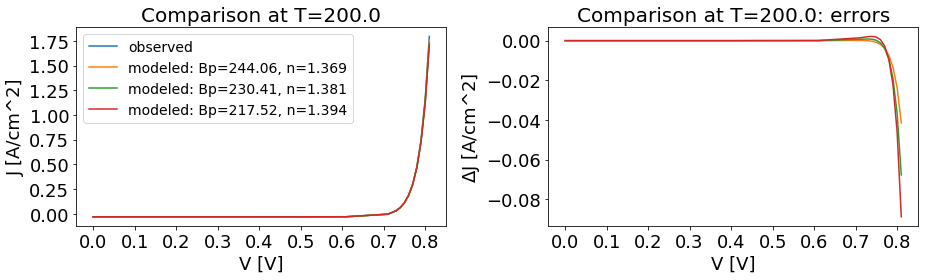

In [47]:
m.comparison_plot(num_param_pts=3, num_ecs=3)

## Et Cetera, et cetera, et cetera...
And you could continue to repeat this process! Eventually you'd get to the point where you can't get any more precision out of the fit because you're limited by the experimental uncertainty.

For now, let's compare our "true" params with the highest-probability ones:

In [ ]:
params

In [ ]:
m.top_probs(1)

In [ ]:
Bp_err = abs((params['Bp']-m.top_probs(1)['Bp'].iloc[0])/params['Bp'])
n_err = abs((params['n']-m.top_probs(1)['n'].iloc[0])/params['n'])
print("Error in B' determination: %.2f%% \nError in n determination: %.2f%%"%(100*Bp_err, 100*n_err))

Not too shabby, I'd say.